In [1]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
import numpy as np
import pandas as pd
from nltk.translate import bleu_score
from nltk.translate.bleu_score import SmoothingFunction
import torch

device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'

processor = TrOCRProcessor.from_pretrained('microsoft/trocr-large-handwritten')
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-large-handwritten').to(device)
model.config.num_beams = 2

/Users/amaljoe/Desktop/Workspace/IITB/NLP/OCR_with_LLMs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 16,
  "num_channels": 3,
  "num_hidden_layers": 24,
  "patch_size": 16,
  "qkv_bias": false,
  "transformers_version": "4.46.2"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRC

In [31]:
CONFIDENCE_THRESHOLD = 0.72
BLEU_THRESHOLD = 0.5
def inference(filepath, debug=False, return_texts='final'):
    def get_cropped_images(filepath):
        image = Image.open(filepath).convert("RGB")
        
        cropped_images = []
        y = []
        for i in range(0, image.height, 50):
            height  = 150
            cropped_image = image.crop((0, i, image.width, i + height))
            cropped_images.append(cropped_image)
            y.append(i)
            
        return cropped_images, y
            
    def get_model_output(images):
        pixel_values = processor(images=images, return_tensors="pt").pixel_values.to(device)
        output = model.generate(pixel_values, return_dict_in_generate=True, output_scores=True, max_new_tokens=30)
        generated_texts = processor.batch_decode(output.sequences, skip_special_tokens=True)
        return generated_texts, output.sequences_scores
    
    def post_process_texts(generated_texts):
        for i in range(len(generated_texts)):
            if len(generated_texts[i]) > 2 and generated_texts[i][:2] == '# ':
                generated_texts[i] = generated_texts[i][2:]
        return generated_texts
    
    def get_qualified_texts(generated_texts, scores, y):
        qualified_texts = []
        for text, score, y_i in zip(generated_texts, scores, y):
            if score > CONFIDENCE_THRESHOLD:
                qualified_texts.append({
                    'text': text,
                    'score': score,
                    'y': y_i
                })
        return qualified_texts
    
    def get_adjacent_bleu_scores(qualified_texts):
        def get_bleu_score(hypothesis, references):
            weights = [0.5, 0.5]
            smoothing = SmoothingFunction()
            return bleu_score.sentence_bleu(references, hypothesis, weights=weights, smoothing_function=smoothing.method1)
        
        for i in range(len(qualified_texts)):
            hyp = qualified_texts[i]['text'].split()
            bleu = 0
            if i < len(qualified_texts) - 1:
                ref = qualified_texts[i + 1]['text'].split()
                bleu = get_bleu_score(hyp, [ref])
            qualified_texts[i]['bleu'] = bleu
        return qualified_texts
            
    def remove_overlapping_texts(qualified_texts):
        final_texts = []
        new = True
        for i in range(len(qualified_texts)):
            if new:
                final_texts.append(qualified_texts[i])
            else:
                if final_texts[-1]['score'] < qualified_texts[i]['score']:
                    final_texts[-1] = qualified_texts[i]
            new = qualified_texts[i]['bleu'] < BLEU_THRESHOLD
        return final_texts

    

    cropped_images, y = get_cropped_images(filepath)
    if debug:
        print('Number of cropped images:', len(cropped_images))
    generated_texts, scores = get_model_output(cropped_images)
    normalised_scores = np.exp(scores.to('cpu').numpy())
    if return_texts == 'generated':
        return pd.DataFrame({
            'text': generated_texts,
            'score': normalised_scores,
            'y': y
        })
    generated_texts = post_process_texts(generated_texts)
    if return_texts == 'post_processed':
        return pd.DataFrame({
            'text': generated_texts,
            'score': normalised_scores,
            'y': y
        })
    qualified_texts = get_qualified_texts(generated_texts, normalised_scores, y)
    if return_texts == 'qualified':
        return pd.DataFrame(qualified_texts)
    qualified_texts = get_adjacent_bleu_scores(qualified_texts)
    if return_texts == 'qualified_with_bleu':
        return pd.DataFrame(qualified_texts)
    final_texts = remove_overlapping_texts(qualified_texts)
    final_texts_df = pd.DataFrame(final_texts, columns=['text', 'score', 'y'])
    return final_texts_df

image_path = 'raw_dataset/b03-092.png'
qualified_texts_df = inference(image_path, debug=False, return_texts='final')
qualified_texts_df

text     score     y
0  Conservative legislation is obviously preferab...  0.739130   100
1  However , disdain this opportunity of obtainin...  0.980618   300
2  parliamentary opinion by at least allowing the...  0.812012   450
3  Centigrade v. Fahrenheit . The fight is on . T...  0.885990   650
4  it not only the authority of the SECRETARY of ...  0.911545   800
5  but also the backing of the DIRECTOR GENERAL o...  0.889148  1000

In [3]:
import os
from tqdm.notebook import tqdm
import shutil

dataset_path = 'raw_dataset'
files = os.listdir(dataset_path)
output  = 'synthetic_labels'

if not os.path.exists(output):
    os.makedirs(output)


for file in tqdm(files[:5]):
    if file[-4:] != '.png':
        continue
    filepath = dataset_path + '/' + file
    csv_file_path = output + '/' + file[:-4] + '.csv'
    qualified_texts_df = inference(filepath)
    qualified_texts_df.to_csv(csv_file_path, index=False)

  0%|          | 0/5 [00:00<?, ?it/s]

/Users/amaljoe/Desktop/Workspace/IITB/NLP/OCR_with_LLMs/.venv/lib/python3.9/site-packages/transformers/generation/utils.py:1493: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed in v5. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


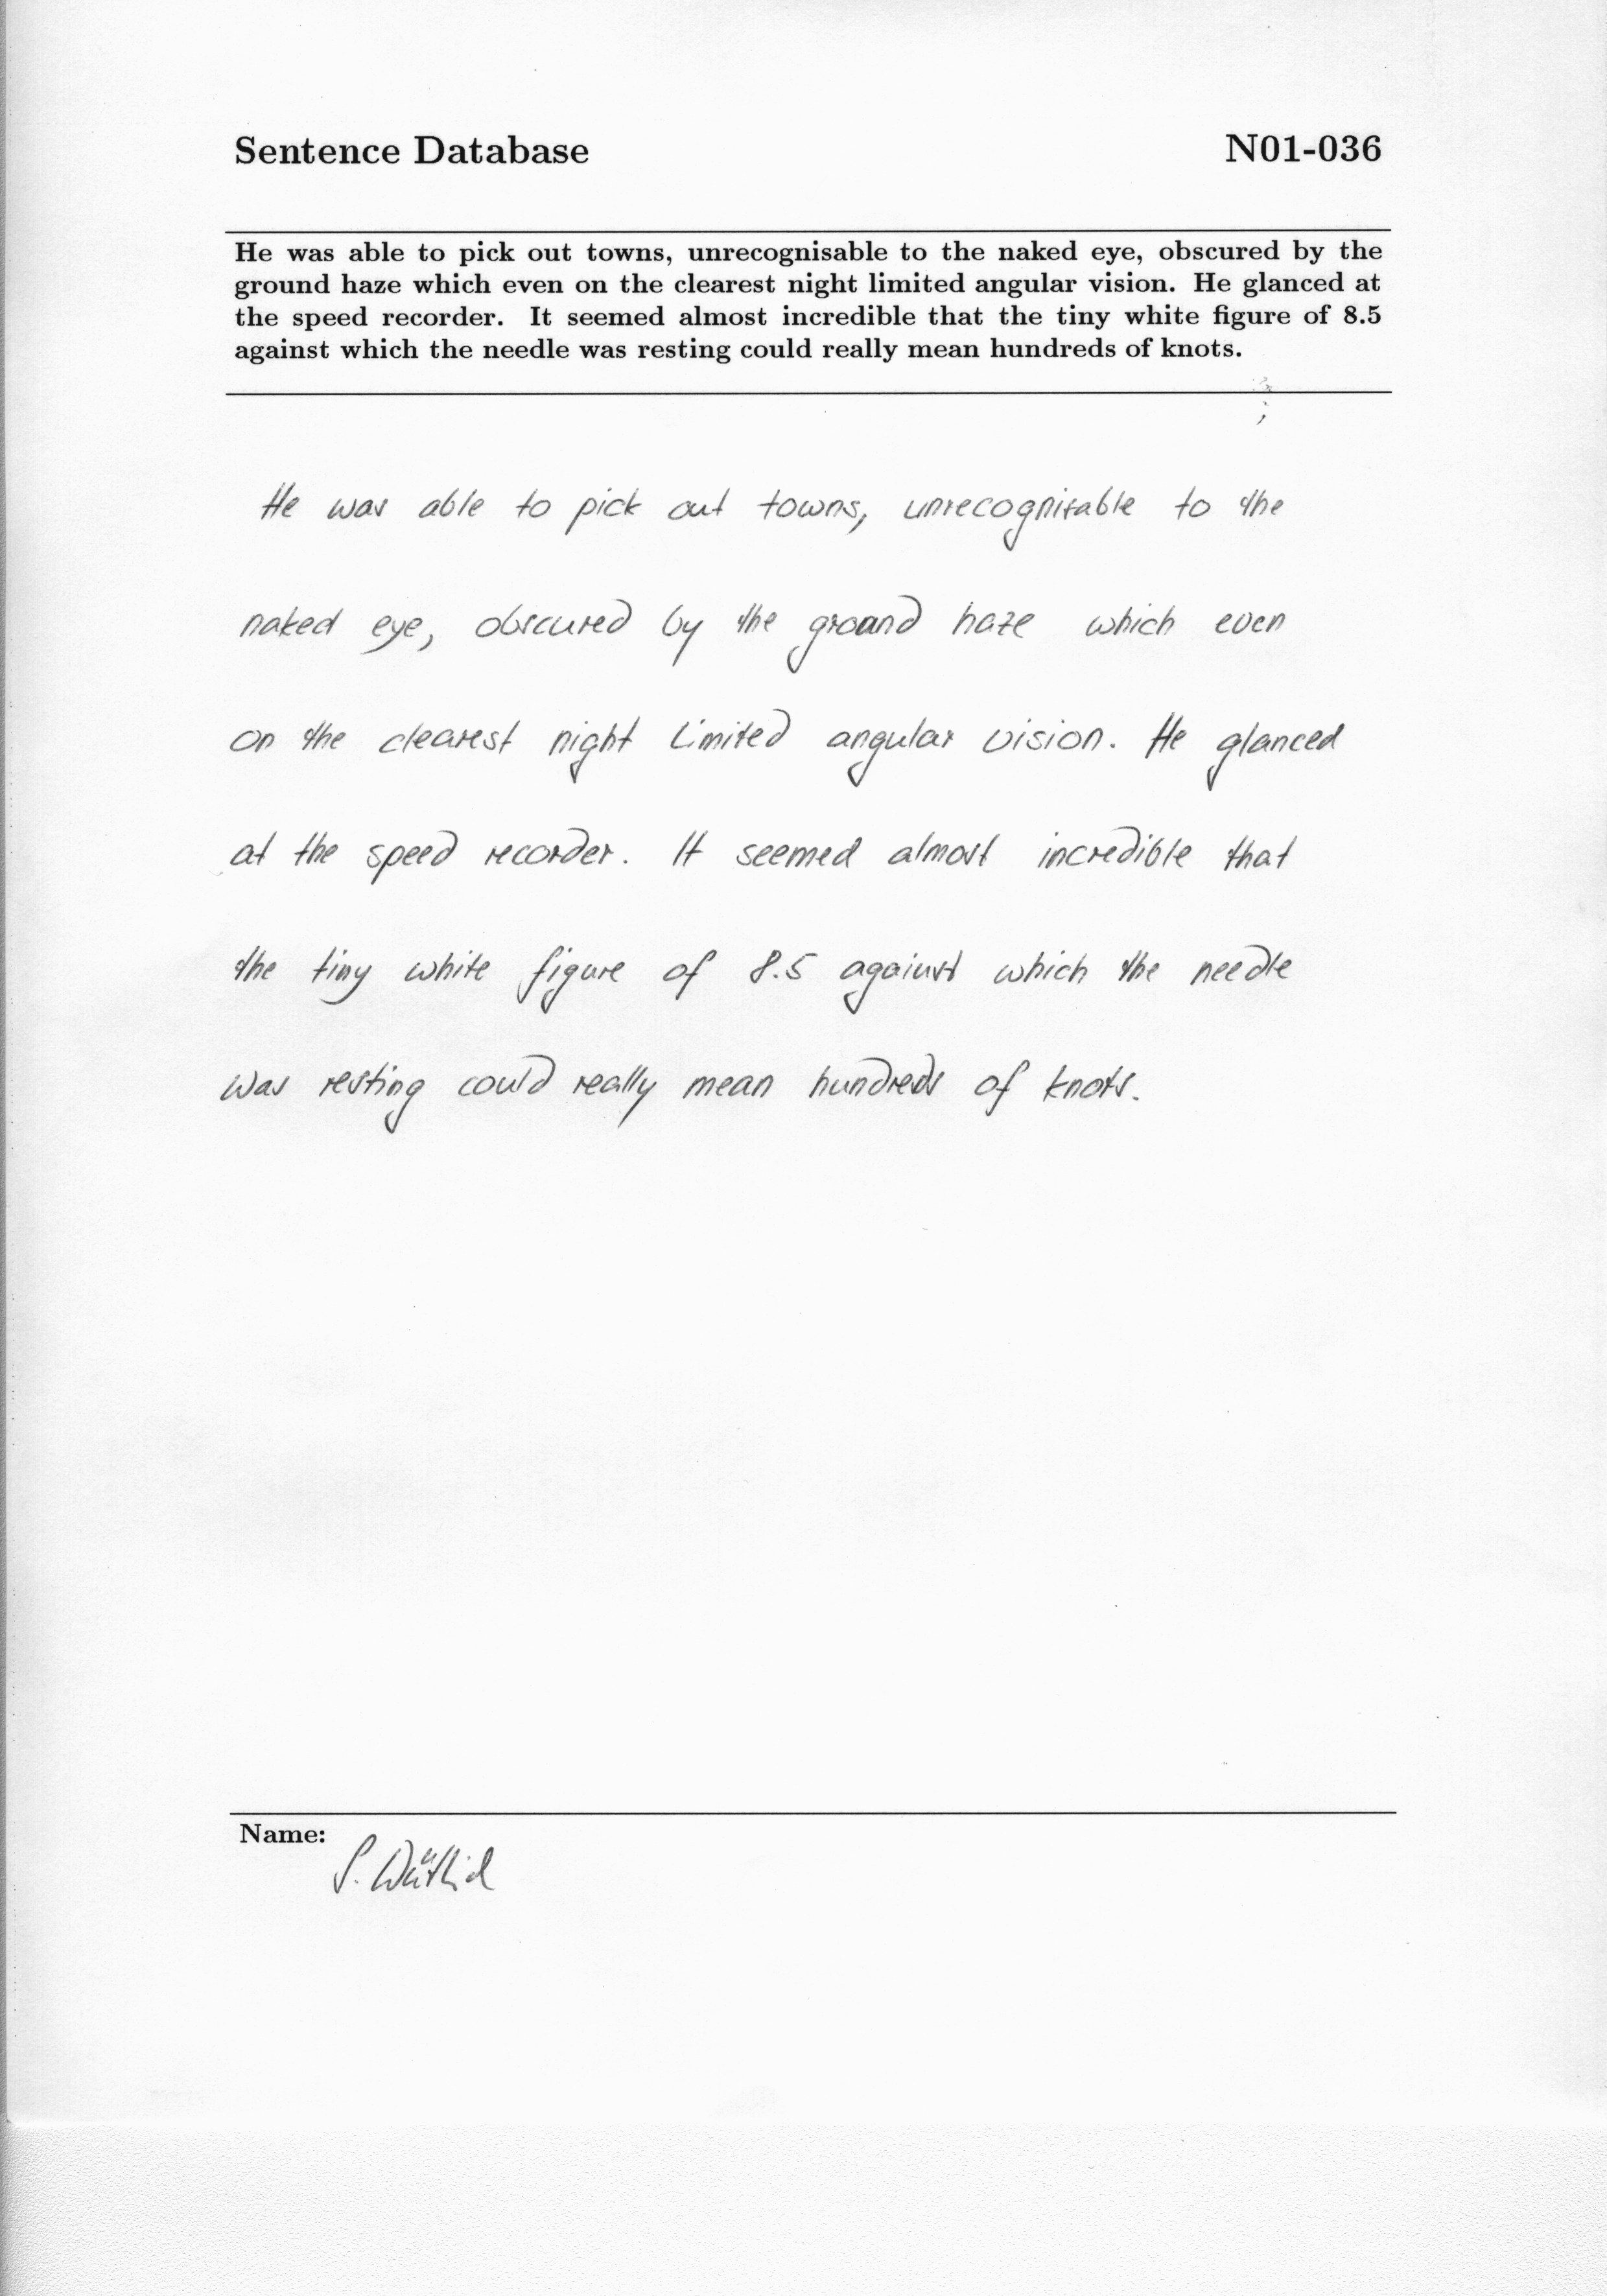

In [40]:
import matplotlib.pyplot as plt

def get_cropped_images(filepath):
    image = Image.open(filepath).convert("RGB")

    cropped_images = []
    y = []
    for i in range(700, image.height - 850, 50):
        height  = 150
        cropped_image = image.crop((0, i, image.width, i + height))
        cropped_images.append(cropped_image)
        y.append(i)

    return cropped_images, y

Image.open(dataset_path + '/556/n01-036.png')
# plt.imshow(get_cropped_images(dataset_path + '/556/n01-036.png')[0][(1400 - 700) // 50])